In [1]:
import pandas as pd
hsd=  pd.read_parquet('/Users/preethamroy/Desktop/SEC/HSD/0000.parquet')

### Step #1 Preprocess the data

In [2]:
import nltk
import numpy as np
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords            #to filterout useless data
stopword = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/preethamroy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
hsd['label'] = hsd['class'].map({0:'Hate Speech',1:'Offensive Language',2:'No Hate and Offensive'})

In [5]:

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [6]:
hsd.tweet = hsd['tweet'].apply(clean)

In [7]:
hsd['tweet']

0        rt mayasolovely woman shouldnt complain cleani...
1        rt boy dats coldtyga dwn bad cuffin dat hoe place
2        rt urkindofbrand dawg rt ever fuck bitch start...
3                 rt cganderson vivabased look like tranny
4        rt shenikaroberts shit hear might true might f...
                               ...                        
24778    yous muthafin lie coreyemanuel right tl trash ...
24779    youve gone broke wrong heart baby drove rednec...
24780    young buck wan na eat dat nigguh like aint fuc...
24781                    youu got wild bitches tellin lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 24783, dtype: object

In [8]:
tweetData = hsd[['tweet','label']].drop_duplicates('tweet')

In [9]:
tweetData.info()


<class 'pandas.core.frame.DataFrame'>
Index: 24506 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24506 non-null  object
 1   label   24506 non-null  object
dtypes: object(2)
memory usage: 574.4+ KB


In [10]:
Lemmatizer =  WordNetLemmatizer()
def lemmatizing(text):
    tweet = [Lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(tweet)

In [11]:
tweetData.tweet  = tweetData['tweet'].apply(lemmatizing)

In [12]:
tweetData['label'].value_counts() # to see distribution of labels


label
Offensive Language       18984
No Hate and Offensive     4113
Hate Speech               1409
Name: count, dtype: int64

In [13]:
# visualizing non-hate tweets
non_hate_tweets = tweetData[tweetData.label=='No Hate and Offensive']
non_hate_tweets.head()

,tweet,label
0,rt mayasolovely woman shouldnt complain cleani...,No Hate and Offensive
40,momma said pussy cat inside doghouse,No Hate and Offensive
63,simplyaddictedtoguys woof woof hot scally lad,No Hate and Offensive
66,allaboutmanfeet woof woof hot sol,No Hate and Offensive
67,allyhaaaaa lemmie eat oreo amp dish one oreo lol,No Hate and Offensive


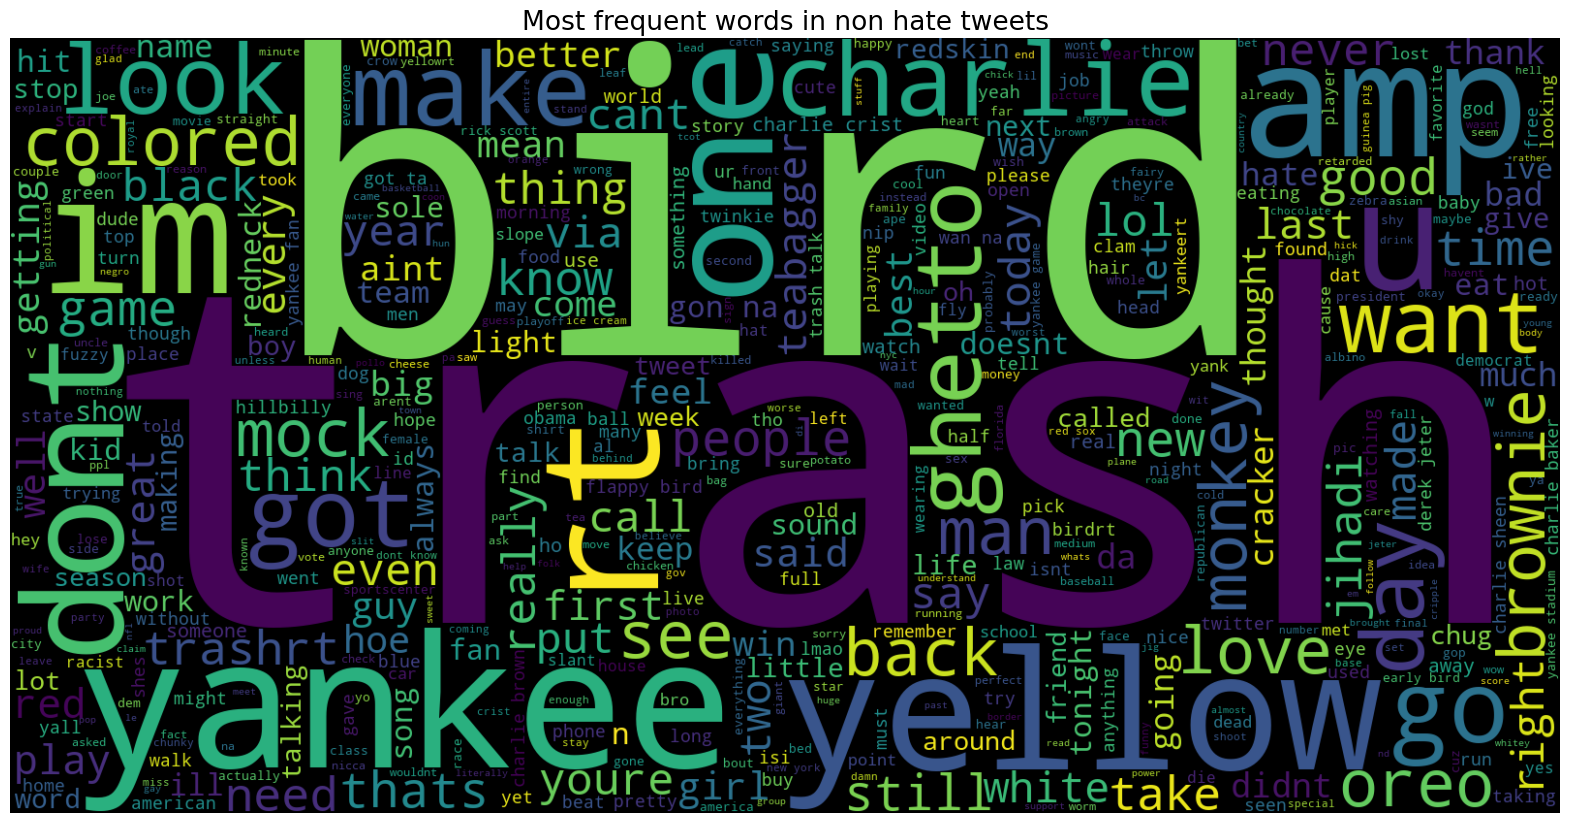

In [14]:
# visualizing non-hate tweets using word cloud
text=''.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

### Split data

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer


vect=TfidfVectorizer(ngram_range=(1,3)).fit(tweetData['tweet'])
feature_names=vect.get_feature_names_out()
feature_names

array(['aa', 'aa class', 'aa class bc', ...,
       'zzzentropy guynamedjordan bitch', 'zzzquil', 'zzzzzz'],
      dtype=object)

In [66]:
X = tweetData.tweet
Y = tweetData.label
X = vect.transform(X)

In [18]:

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [19]:
#printing the size of training and testing data
print("Size of X_train", (X_train.shape))
print("Size of Y_train", (Y_train.shape))
print("Size of X_test", (X_test.shape))
print("Size of Y_test", (Y_test.shape))

Size of X_train (19604, 303251)
Size of Y_train (19604,)
Size of X_test (4902, 303251)
Size of Y_test (4902,)


### Model Training and Testing

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
#for training the data on logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train) #loading x_train and y_train data on model
logreg_predict = logreg.predict(X_test) #predicting the value for test data
logreg_acc = accuracy_score(logreg_predict, Y_test)

In [67]:
import pickle
pickle.dump(logreg, open('trained_HSD.sav', 'wb'))
pickle.dump(vect.vocabulary_, open('vectorizer_HSD.pkl', 'wb'))

In [82]:
print("Test accuracy: {:.2f}%".format(logreg_acc*100)) #printing accuracy of the model


Test accuracy: 86.21%


array(['Offensive Language'], dtype=object)

In [22]:
#printing confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix


print(confusion_matrix(Y_test, logreg_predict))
print("\n")
print(classification_report(Y_test, logreg_predict))

[[  14   10  259]
 [   0  447  361]
 [   3   43 3765]]


                       precision    recall  f1-score   support

          Hate Speech       0.82      0.05      0.09       283
No Hate and Offensive       0.89      0.55      0.68       808
   Offensive Language       0.86      0.99      0.92      3811

             accuracy                           0.86      4902
            macro avg       0.86      0.53      0.57      4902
         weighted avg       0.86      0.86      0.83      4902



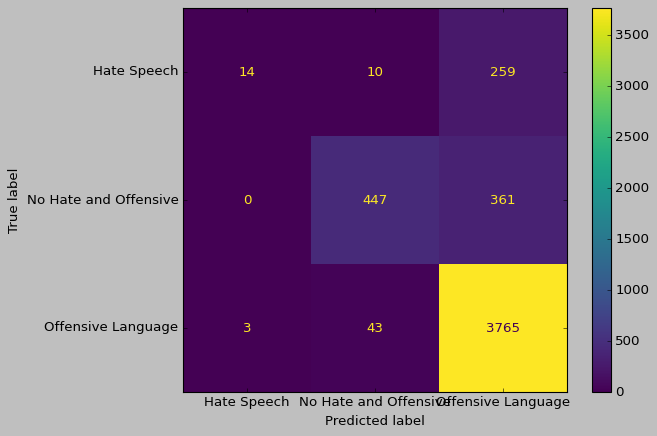

In [23]:
from matplotlib.pyplot import style
from sklearn.metrics import ConfusionMatrixDisplay


style.use('classic')
cm = confusion_matrix(Y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [24]:
#for performing hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [25]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(X_train, Y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.89
Best parameters:  {'C': 100, 'solver': 'lbfgs'}


In [26]:
log_grid_pred = grid.predict(X_test)


In [27]:
log_grid_acc = accuracy_score(log_grid_pred, Y_test)
print("Test accuracy: {:.2f}%".format(log_grid_acc*100)) #printing model accuracy after applying hyperparamenter tuning

Test accuracy: 89.21%


In [28]:
print(confusion_matrix(Y_test, log_grid_pred))
print("\n")
print(classification_report(Y_test, log_grid_pred))

[[  26   19  238]
 [   1  639  168]
 [  18   85 3708]]


                       precision    recall  f1-score   support

          Hate Speech       0.58      0.09      0.16       283
No Hate and Offensive       0.86      0.79      0.82       808
   Offensive Language       0.90      0.97      0.94      3811

             accuracy                           0.89      4902
            macro avg       0.78      0.62      0.64      4902
         weighted avg       0.88      0.89      0.87      4902



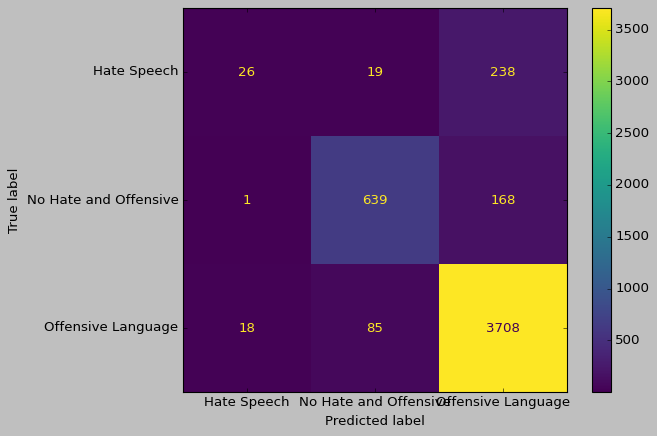

In [29]:
#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, log_grid_pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()